## Tigray War Demand and Utility Analysis

##### *This notebook walks through the cleaning and analysis of Ehtiopia's food and expenditure data to understand the impacts of the Tigray War on demand and utility.*

In [2]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [3]:
Ethiopia_Data = '1PVqM25qZyDz5K3jsLDu-JgPS5-vmro4wHk8k6OIB9Eo'

In [4]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Ethiopia_Data,sheet='Food Expenditures (2018-19)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia_Data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

p = p['Price']

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

jidx = p.columns.intersection(x.index.levels[-1])
# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Household characteristics
d = read_sheets(Ethiopia_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

In [5]:
d.head()

k                             Females 00-03  Females 04-08  Females 09-13  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              1              1              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              1              1   
              2013-14 Tigray              1              1              1   

k                             Females 14-18  Females 19-30  Females 31-50  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              0              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              1              0   

k                             Females 51-99  Males 00-03  Males 04-08  \
i             t       m                                                 
1010101601002 2011-12 Tigray              1            0            1   
              2013-14 Tigray              1            0            1   
              2015-16 Tigray              1            0            0   
1010101601017 2011-12 Tigray              0            0            0   
              2013-14 Tigray              0            0            1   

k                             Males 09-13  Males 14-18  Males 19-30  \
i             t       m                                               
1010101601002 2011-12 Tigray            1            1            0   
              2013-14 Tigray            0            1            0   
              2015-16 Tigray            0            0            0   
1010101601017 2011-12 Tigray            2            0            0   
              2013-14 Tigray            1            1            0   

k                             Males 31-50  Males 51-99  log HSize  
i             t       m                                            
1010101601002 2011-12 Tigray            1            0   1.945910  
              2013-14 Tigray            1            0   2.079442  
              2015-16 Tigray            0            0   0.000000  
1010101601017 2011-12 Tigray            1            0   1.791759  
              2013-14 Tigray            1            0   2.079442

In [6]:
from cfe import Regression

result = Regression(y=y,d=d)

In [7]:
result.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.616372
                                     Barley       29.423663
                                     Beef        152.220021
                                     Beetroot      9.713831
                                     Berbere      18.635439
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.199711
                                     Tea           6.688172
                                     Teff         65.156824
                                     Tomato        7.975005
                                     Wheat        22.539978
Length: 191958, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

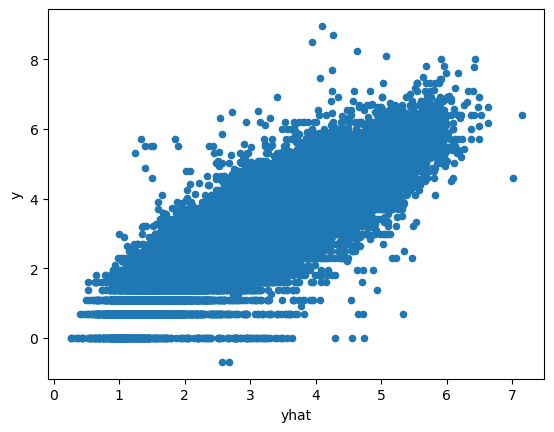

In [8]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

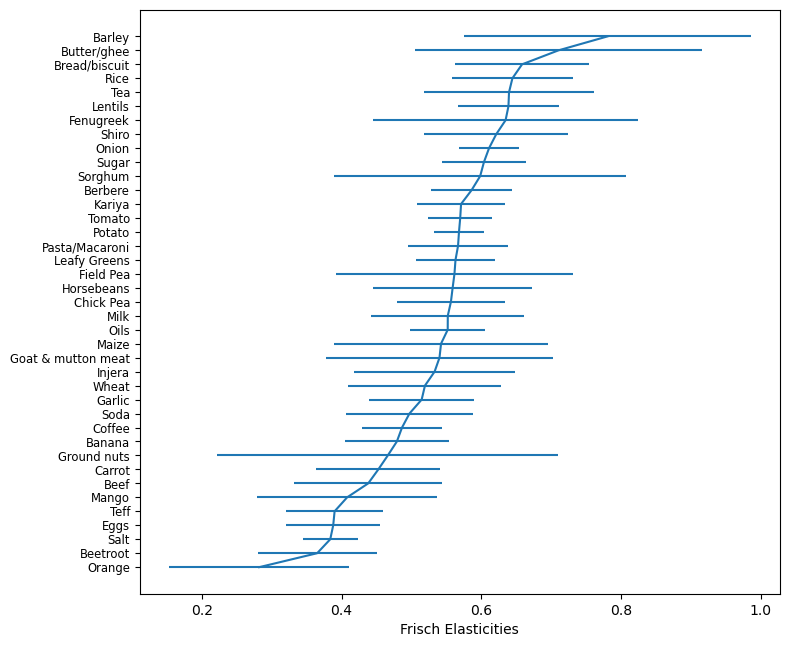

In [9]:
ax = result.graph_beta()

In [10]:
result.get_beta()

j
Banana                0.479178
Barley                0.780838
Beef                  0.438144
Beetroot              0.365002
Berbere               0.586266
Bread/biscuit         0.658454
Butter/ghee           0.710548
Carrot                0.452613
Chick Pea             0.556580
Coffee                0.486573
Eggs                  0.388004
Fenugreek             0.634856
Field Pea             0.561645
Garlic                0.514700
Goat & mutton meat    0.540216
Ground nuts           0.466189
Horsebeans            0.559037
Injera                0.533212
Kariya                0.571094
Leafy Greens          0.563143
Lentils               0.638976
Maize                 0.542419
Mango                 0.407950
Milk                  0.552095
Oils                  0.551995
Onion                 0.611191
Orange                0.281921
Pasta/Macaroni        0.566775
Potato                0.568128
Rice                  0.644632
Salt                  0.383775
Shiro                 0.621482
Soda  

In [11]:
result.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,0.011810,-0.064620,0.000871,0.013443,0.133738,0.141644,0.126503,0.032934,-0.077769,-0.049908,-0.024724,0.047068,0.238964,0.059762,0.166232,3.186060
Barley,0.129997,0.022144,0.173119,0.077375,-0.023983,0.051273,0.124006,-0.139137,0.056104,-0.066169,0.095584,0.093987,-0.005463,0.006414,0.308662,3.280411
Beef,-0.038712,-0.143079,-0.044804,0.106981,0.082911,0.092443,0.093977,-0.017334,-0.050165,-0.076351,0.018740,0.046138,0.188003,0.155703,0.228814,5.246494
Beetroot,0.001029,0.022451,0.057436,0.076431,0.059910,0.023900,-0.043512,0.070262,0.071069,0.040267,0.120961,0.129963,0.122618,0.163502,-0.012407,2.569000
Berbere,-0.048073,-0.076586,-0.059522,0.014102,0.079845,0.109970,0.018191,-0.013862,-0.038025,-0.067903,-0.052288,0.012149,0.103575,0.015762,0.190950,3.278676
Bread/biscuit,-0.094437,-0.116391,-0.057850,-0.042674,-0.024460,-0.058130,-0.063316,-0.096493,-0.043789,0.006290,0.008206,-0.004942,0.105722,0.068624,0.520533,3.355363
Butter/ghee,-0.098656,-0.075701,-0.051734,-0.101765,-0.047569,-0.035877,-0.051663,-0.054609,-0.235991,-0.156610,0.023816,-0.203628,-0.137815,-0.237530,0.574928,4.063996
Carrot,-0.099693,-0.061000,-0.004635,0.124506,0.103096,0.082780,-0.039283,-0.039865,0.064992,-0.022887,0.013635,-0.029045,0.097049,0.049188,0.158515,2.586238
Chick Pea,-0.020002,0.065625,0.095818,0.039758,0.003700,-0.026125,0.038652,-0.027231,0.067941,0.005538,0.099321,0.063872,0.058138,0.181637,0.230669,3.171293


<Axes: ylabel='Density'>

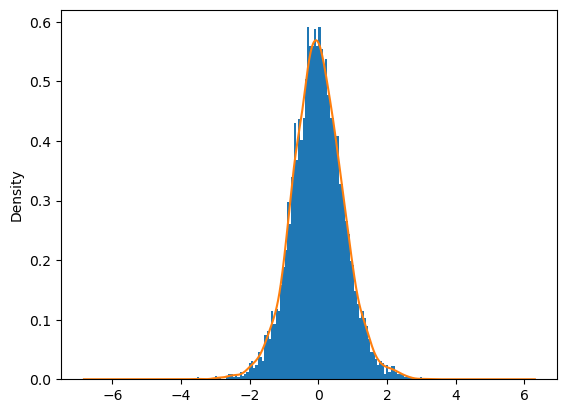

In [12]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [13]:
result.to_pickle('ethiopia_estimates.rgsn')

In [14]:
import cfe
result = cfe.regression.read_pickle('ethiopia_estimates.rgsn')

In [15]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [16]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Milk Demanded')

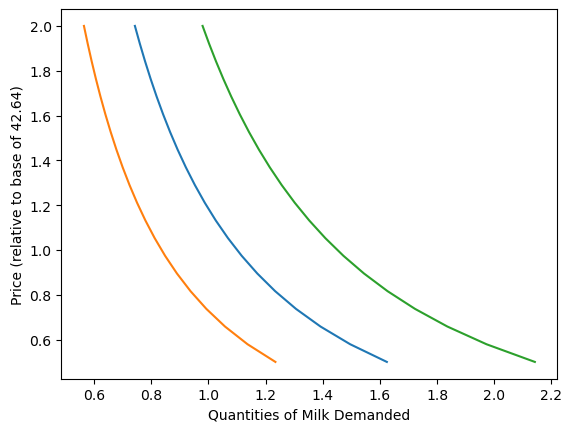

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

    # UNCOMMENT BELOW AND REPLACE STRING WITH FOOD
use = 'Milk'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

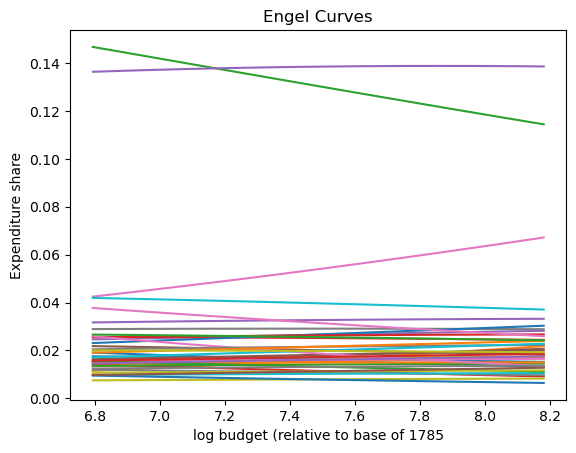

In [18]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

Text(0.5, 1.0, 'Indirect Utility Function')

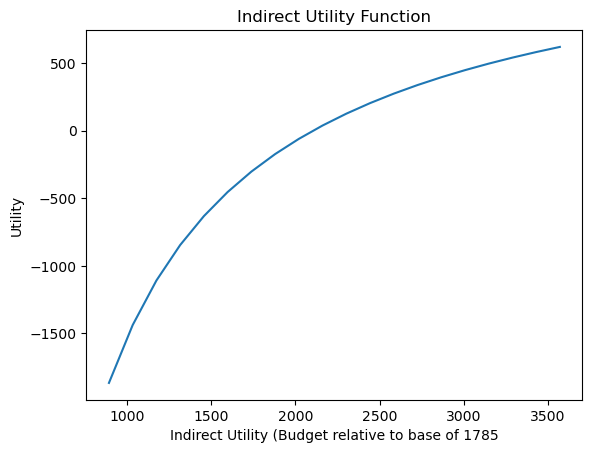

In [19]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

In [26]:
def simulate_scenario(budget_multiplier=1.0, price_multipliers=None):
    """
    Simulate a scenario by altering the total food expenditure and food prices.
    
    Parameters:
    - budget_multiplier: float, multiplier for the reference budget (e.g., 0.8 for a 20% drop).
    - price_multipliers: dict, mapping of good names to their price multipliers 
                         (e.g., {"Milk": 1.5, "Millet": 1.3}).
    
    Returns:
    - demands: Series with the predicted consumption (quantities) for each food item.
    - total_consumption: Total consumption across all food items.
    """
    # Use the reference budget defined in the code (e.g., median total food expenditure)
    new_budget = xref * budget_multiplier

    # Create a new price vector by starting with the base prices (pbar)
    new_prices = pbar.copy()
    if price_multipliers is not None:
        for good, multiplier in price_multipliers.items():
            if good in new_prices.index:
                new_prices.loc[good] *= multiplier
            else:
                print(f"Warning: {good} not found in the price vector.")

    # Compute the predicted demands under the new scenario
    demands = result.demands(new_budget, new_prices)
    
    # Sum the consumption across all goods for the total consumption
    total_consumption = demands.sum()
    
    return demands, total_consumption

# Example usage:
# Suppose that due to the civil war, households face a 20% reduction in their total expenditure
# and prices for "Milk" and "Banana" increase by 50% and 1000%, respectively.
scenario_params = {
    "budget_multiplier": 0.8,
    "price_multipliers": {"Milk": 1.5, "Banana": 100}
}

demands, total_consumption = simulate_scenario(**scenario_params)

print("Predicted Consumption by Good:")
print(demands)
print("\nTotal Food Consumption:", total_consumption)


Predicted Consumption by Good:
j
Banana                0.068782
Barley                0.545159
Beef                  0.651224
Beetroot              0.613882
Berbere               0.313189
Bread/biscuit         0.574157
Butter/ghee           0.201579
Carrot                0.556106
Chick Pea             0.529627
Coffee                0.359979
Eggs                  0.945313
Fenugreek             0.227344
Field Pea             0.474326
Garlic                0.283215
Goat & mutton meat    0.539638
Ground nuts           0.386281
Horsebeans            0.533774
Injera                0.750515
Kariya                0.366486
Leafy Greens          0.611292
Lentils               0.457223
Maize                 1.096133
Mango                 0.735189
Milk                  0.588966
Oils                  0.498301
Onion                 0.582019
Orange                0.809124
Pasta/Macaroni        0.658772
Potato                0.746278
Rice                  0.737201
Salt                  0.382187
Shiro 

In [27]:
# Compute baseline consumption (using reference budget and prices)
baseline_demands = result.demands(xref, pbar)

scenario_demands, _ = simulate_scenario(**scenario_params)

# Calculate the difference: Case Study Consumption - Baseline Consumption
consumption_difference = scenario_demands - baseline_demands

# Print the array of differences
print("Differences in consumption (Case Study - Baseline):")
print(consumption_difference)

Differences in consumption (Case Study - Baseline):
j
Banana               -0.816075
Barley               -0.415672
Beef                 -0.243801
Beetroot             -0.186201
Berbere              -0.166103
Bread/biscuit        -0.351773
Butter/ghee          -0.136029
Carrot               -0.216260
Chick Pea            -0.263617
Coffee               -0.152466
Eggs                 -0.307471
Fenugreek            -0.133063
Field Pea            -0.238707
Garlic               -0.128268
Goat & mutton meat   -0.259058
Ground nuts          -0.155530
Horsebeans           -0.267108
Injera               -0.354658
Kariya               -0.188227
Leafy Greens         -0.308636
Lentils              -0.269781
Maize                -0.528804
Mango                -0.253334
Milk                 -0.510881
Oils                 -0.245545
Onion                -0.324939
Orange               -0.183713
Pasta/Macaroni       -0.335225
Potato               -0.380860
Rice                 -0.439800
Salt            

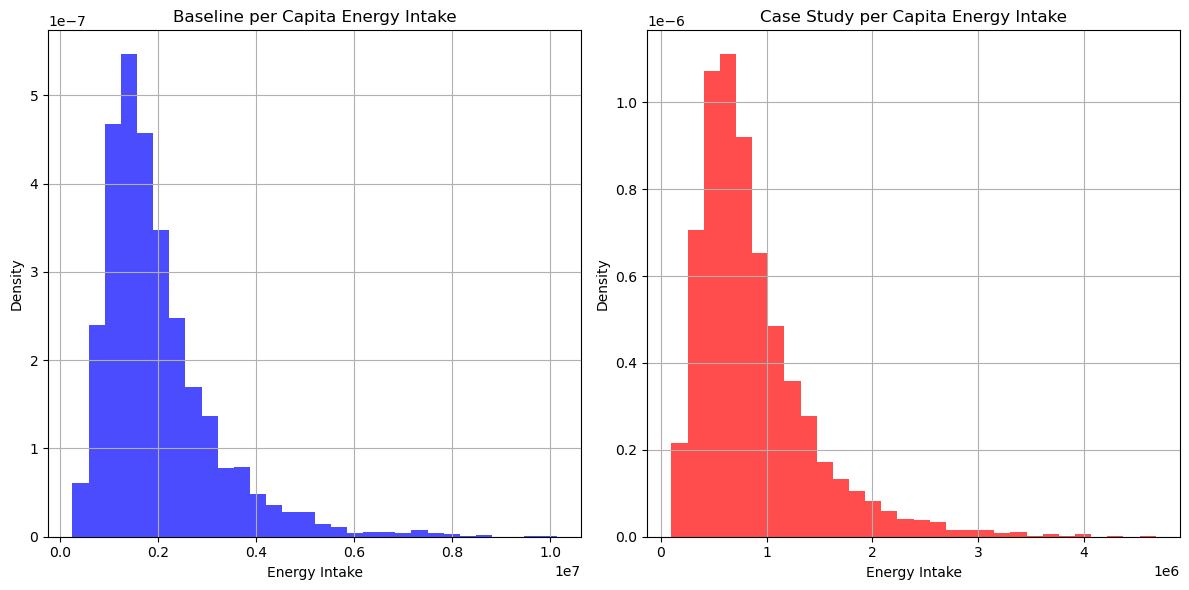

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#
# - baseline_xhat is a Series with a MultiIndex (i, t, m, j), where:
#     i = household ID, t = time, m = market/region, j = food item.
#   Its values are the predicted quantity of each food item purchased per period.
#
# - fct is a DataFrame from the "FCT Sorted" sheet, with:
#     index = food items (matching j in xhat)
#     columns = nutrients (e.g., "Energy", "Protein", etc.)
#
# - d is a DataFrame of household characteristics, indexed by (i, t, m),
#   with a column 'log HSize' (the natural log of household size).
#
# - We want to compute per capita nutrient intake at the household level.
#
# NOTE: The unit conversion (from kg to grams, monthly to daily, etc.) has been removed.
# -----------------------------------------------------------------------------

# ----- STEP 0: Prepare Baseline Consumption and Food Composition Data -----

# Get baseline consumption (household-level predicted quantities)
baseline_xhat = result.predicted_expenditures()

# Load the Food Composition Table (FCT)
fct = read_sheets(Ethiopia_Data, sheet="FCT Sorted").set_index("index")

# pbar is the reference price vector (prices per unit) computed earlier.
# (Assume pbar is already defined and aligned with the goods in baseline_xhat)

# ----- Modified Simulation Function: Adjust for Budget and Specific Price Changes -----

def simulate_scenario_for_all(baseline_xhat, pbar, budget_multiplier=0.8, price_multipliers=None):
    """
    For each household, adjust consumption based on a change in overall food expenditure
    and specific price changes for selected goods.
    
    Parameters:
    - baseline_xhat: Series with MultiIndex (i, t, m, j) containing baseline consumption.
    - pbar: Series with reference prices indexed by food item (j).
    - budget_multiplier: float, multiplier for overall food expenditure.
    - price_multipliers: dict, mapping food names (j) to price multipliers 
                         (e.g., {"Banana": 10, "Milk": 2}).
    
    Returns:
    - scenario_xhat: Series with MultiIndex (i, t, m, j) of simulated consumption under the scenario.
    """
    simulated_results = []  # To hold simulated consumption for each household
    
    # Group the baseline consumption by household (i, t, m)
    for household, group in baseline_xhat.groupby(level=['i', 't', 'm']):
        # Drop household levels so that index becomes food items (j)
        group = group.droplevel(['i', 't', 'm'])
        
        # Compute baseline household expenditure: sum over goods of (quantity * reference price)
        common_goods = group.index.intersection(pbar.index)
        baseline_expenditure = (group.loc[common_goods] * pbar.loc[common_goods]).sum()
        
        # Apply the overall budget multiplier
        new_budget = baseline_expenditure * budget_multiplier
        
        # Create a new price vector from pbar and adjust for specified price multipliers
        new_prices = pbar.copy()
        if price_multipliers is not None:
            for food, mult in price_multipliers.items():
                if food in new_prices.index:
                    new_prices.loc[food] *= mult
                else:
                    print(f"Warning: {food} not found in the price vector.")
        
        # Use the demand function from your regression model to get new consumption.
        # (Assumes result.demands returns a Series indexed by food item with consumption values.)
        new_consumption = result.demands(new_budget, new_prices)
        
        # Convert the household-level consumption Series to a DataFrame and stack it to restore full index.
        df_household = pd.DataFrame(new_consumption).T
        df_household.index = pd.MultiIndex.from_tuples([household], names=['i', 't', 'm'])
        df_household = df_household.stack()
        df_household.name = 'consumption'
        
        simulated_results.append(df_household)
    
    # Combine results for all households into a single Series
    scenario_xhat = pd.concat(simulated_results)
    return scenario_xhat

# Example: Set Banana to 10x and Milk to 2x more expensive, with overall expenditure at 50% of baseline.
price_multipliers = {"Banana": 10, "Milk": 2}
scenario_xhat = simulate_scenario_for_all(baseline_xhat, pbar, budget_multiplier=0.3, price_multipliers=price_multipliers)

# ----- STEP 1: Ensure Household Characteristics Are Correctly Indexed -----

# d should be indexed by (i, t, m). Set its index names:
d.index.names = ['i', 't', 'm']
# Convert log HSize to actual household size.
d['HSize'] = np.exp(d['log HSize'])

# ----- STEP 2: Define a Function to Compute Per Capita Nutrient Intake -----

def compute_nutrient_intake(xhat_input):
    """
    Converts consumption (xhat) into per capita nutrient intakes.
    Assumes xhat is provided as a MultiIndex Series (i, t, m, j).
    Note: No unit conversion is performed.
    """
    # A. Unstack the MultiIndex so that food items (j) become columns.
    if isinstance(xhat_input, pd.Series):
        if isinstance(xhat_input.index, pd.MultiIndex):
            xhat_df = xhat_input.unstack(level='j')
        else:
            xhat_df = pd.DataFrame(xhat_input).T
    else:
        xhat_df = xhat_input.copy()
    
    # Use consumption data directly (no unit conversions)
    common_foods = xhat_df.columns.intersection(fct.index)
    if common_foods.empty:
        raise ValueError("No common food items between consumption data and FCT data.")
    xhat_aligned = xhat_df[common_foods]
    fct_aligned = fct.loc[common_foods]
    
    # Compute total nutrient intake at the household level (dot product)
    nutrient_intake = xhat_aligned.dot(fct_aligned)
    
    # Ensure the index is a MultiIndex with levels (i, t, m)
    if not isinstance(nutrient_intake.index, pd.MultiIndex):
        nutrient_intake = pd.DataFrame(nutrient_intake).T
    nutrient_intake.index.names = d.index.names  # Set index names to ['i', 't', 'm']
    
    # Merge with household size to compute per capita intakes
    nutrient_intake = nutrient_intake.merge(d[['HSize']], left_index=True, right_index=True)
    nutrient_intake_per_capita = nutrient_intake.drop(columns=['HSize']).div(nutrient_intake['HSize'], axis=0)
    
    return nutrient_intake_per_capita

# ----- STEP 3: Compute Nutrient Intakes for Both Baseline and Scenario -----

baseline_nutrient = compute_nutrient_intake(baseline_xhat)
scenario_nutrient = compute_nutrient_intake(scenario_xhat)

# ----- STEP 4: Plot Side-by-Side Histograms for a Specified Nutrient -----

# Choose the nutrient to plot (e.g., "Energy", "Protein", "Niacin", etc.)
nutrient = "Energy"  # Change this as needed

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(baseline_nutrient[nutrient], bins=30, density=True, alpha=0.7, color='blue')
plt.title(f"Baseline per Capita {nutrient} Intake")
plt.xlabel(f"{nutrient} Intake")
plt.ylabel("Density")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(scenario_nutrient[nutrient], bins=30, density=True, alpha=0.7, color='red')
plt.title(f"Case Study per Capita {nutrient} Intake")
plt.xlabel(f"{nutrient} Intake")
plt.ylabel("Density")
plt.grid(True)

plt.tight_layout()
plt.show()
